## Plot SSAM 
Untuk data dari NSI

### 1. Gabungkan file 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Definisikan directory data, nama gunung, dan nama stasiun
directory = r"D:/Jupyter Plot/Slamet"
gunung = 'SLAMET'
stasiun = "CLKZ"
komponen = "EHZ"

# Tentukan waktu awal dan waktu akhir
waktu_awal = '01-12-2024'
waktu_akhir = '17-12-2024'
interval_hari = 1

# Mengambil nilai bulan dan tahun
start_year = int(waktu_awal[6:])
start_month = int(waktu_awal[3:5])
end_year = int(waktu_akhir[6:])
end_month = int(waktu_akhir[3:5])

# Proses menggabungkan file-file 
merged_data = pd.DataFrame()
files_to_merge = []  
for filename in os.listdir(directory):
    if filename.endswith(".dat"):
        # Membaca nama file
        try:
            year = int(filename[5:9])
            month = int(filename[9:11])
            channel_name = filename[12:16]
            component = filename[17:20]
        except ValueError:
            # Skip file jika tidak dapat di-parse sebagai angka untuk tahun dan bulan
            continue
        # Memeriksa apakah file cocok dengan kriteria sesuai nama stasiun, waktu awal, dan waktu akhir yang ditentukan sebelumnya
        if (start_year < end_year):
            if ((year == start_year and month >= start_month) or (year == end_year and month <= end_month)) and channel_name == stasiun and component == komponen:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['DateTime', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5', '5.5', '6', '8', '10', '15', '20'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)
        else:
            if (year == start_year and month >= start_month and year == end_year and month <= end_month) and channel_name == stasiun and component == komponen:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['DateTime', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5', '5.5', '6', '8', '10', '15', '20'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)

print("\nFile : ")
for item in files_to_merge:
    print(item)
print("________________________________")
print("\nData (5 baris pertama dan terakhir) :")
print(merged_data)




File : 
SSAM_202412_CLKZ_EHZ_VG_00_16.dat
________________________________

Data (5 baris pertama dan terakhir) :
                        DateTime  0.5    1  1.5   2  2.5   3  3.5   4  4.5  \
0      01-December-2024 07:31:00   15   13   26  33   43  45   36  32   28   
1      01-December-2024 07:33:00   14   14   20  42   55  43   41  36   25   
2      01-December-2024 07:34:00   17   14   25  39   54  48   44  31   27   
3      01-December-2024 07:35:00   14   16   22  38   59  46   39  28   24   
4      01-December-2024 07:36:00   15   14   23  35   40  39   36  31   26   
...                          ...  ...  ...  ...  ..  ...  ..  ...  ..  ...   
17086  17-December-2024 08:54:00   14   12   10  17   46  59   43  22   21   
17087  17-December-2024 08:55:00   13    9   11  19   38  65   43  22   23   
17088  17-December-2024 08:56:00   14    9    8  16   38  53   34  17   18   
17089  17-December-2024 08:57:00   62  110   97  79   72  89   52  35   23   
17090  17-December-2024 08:

### 2. Plot 

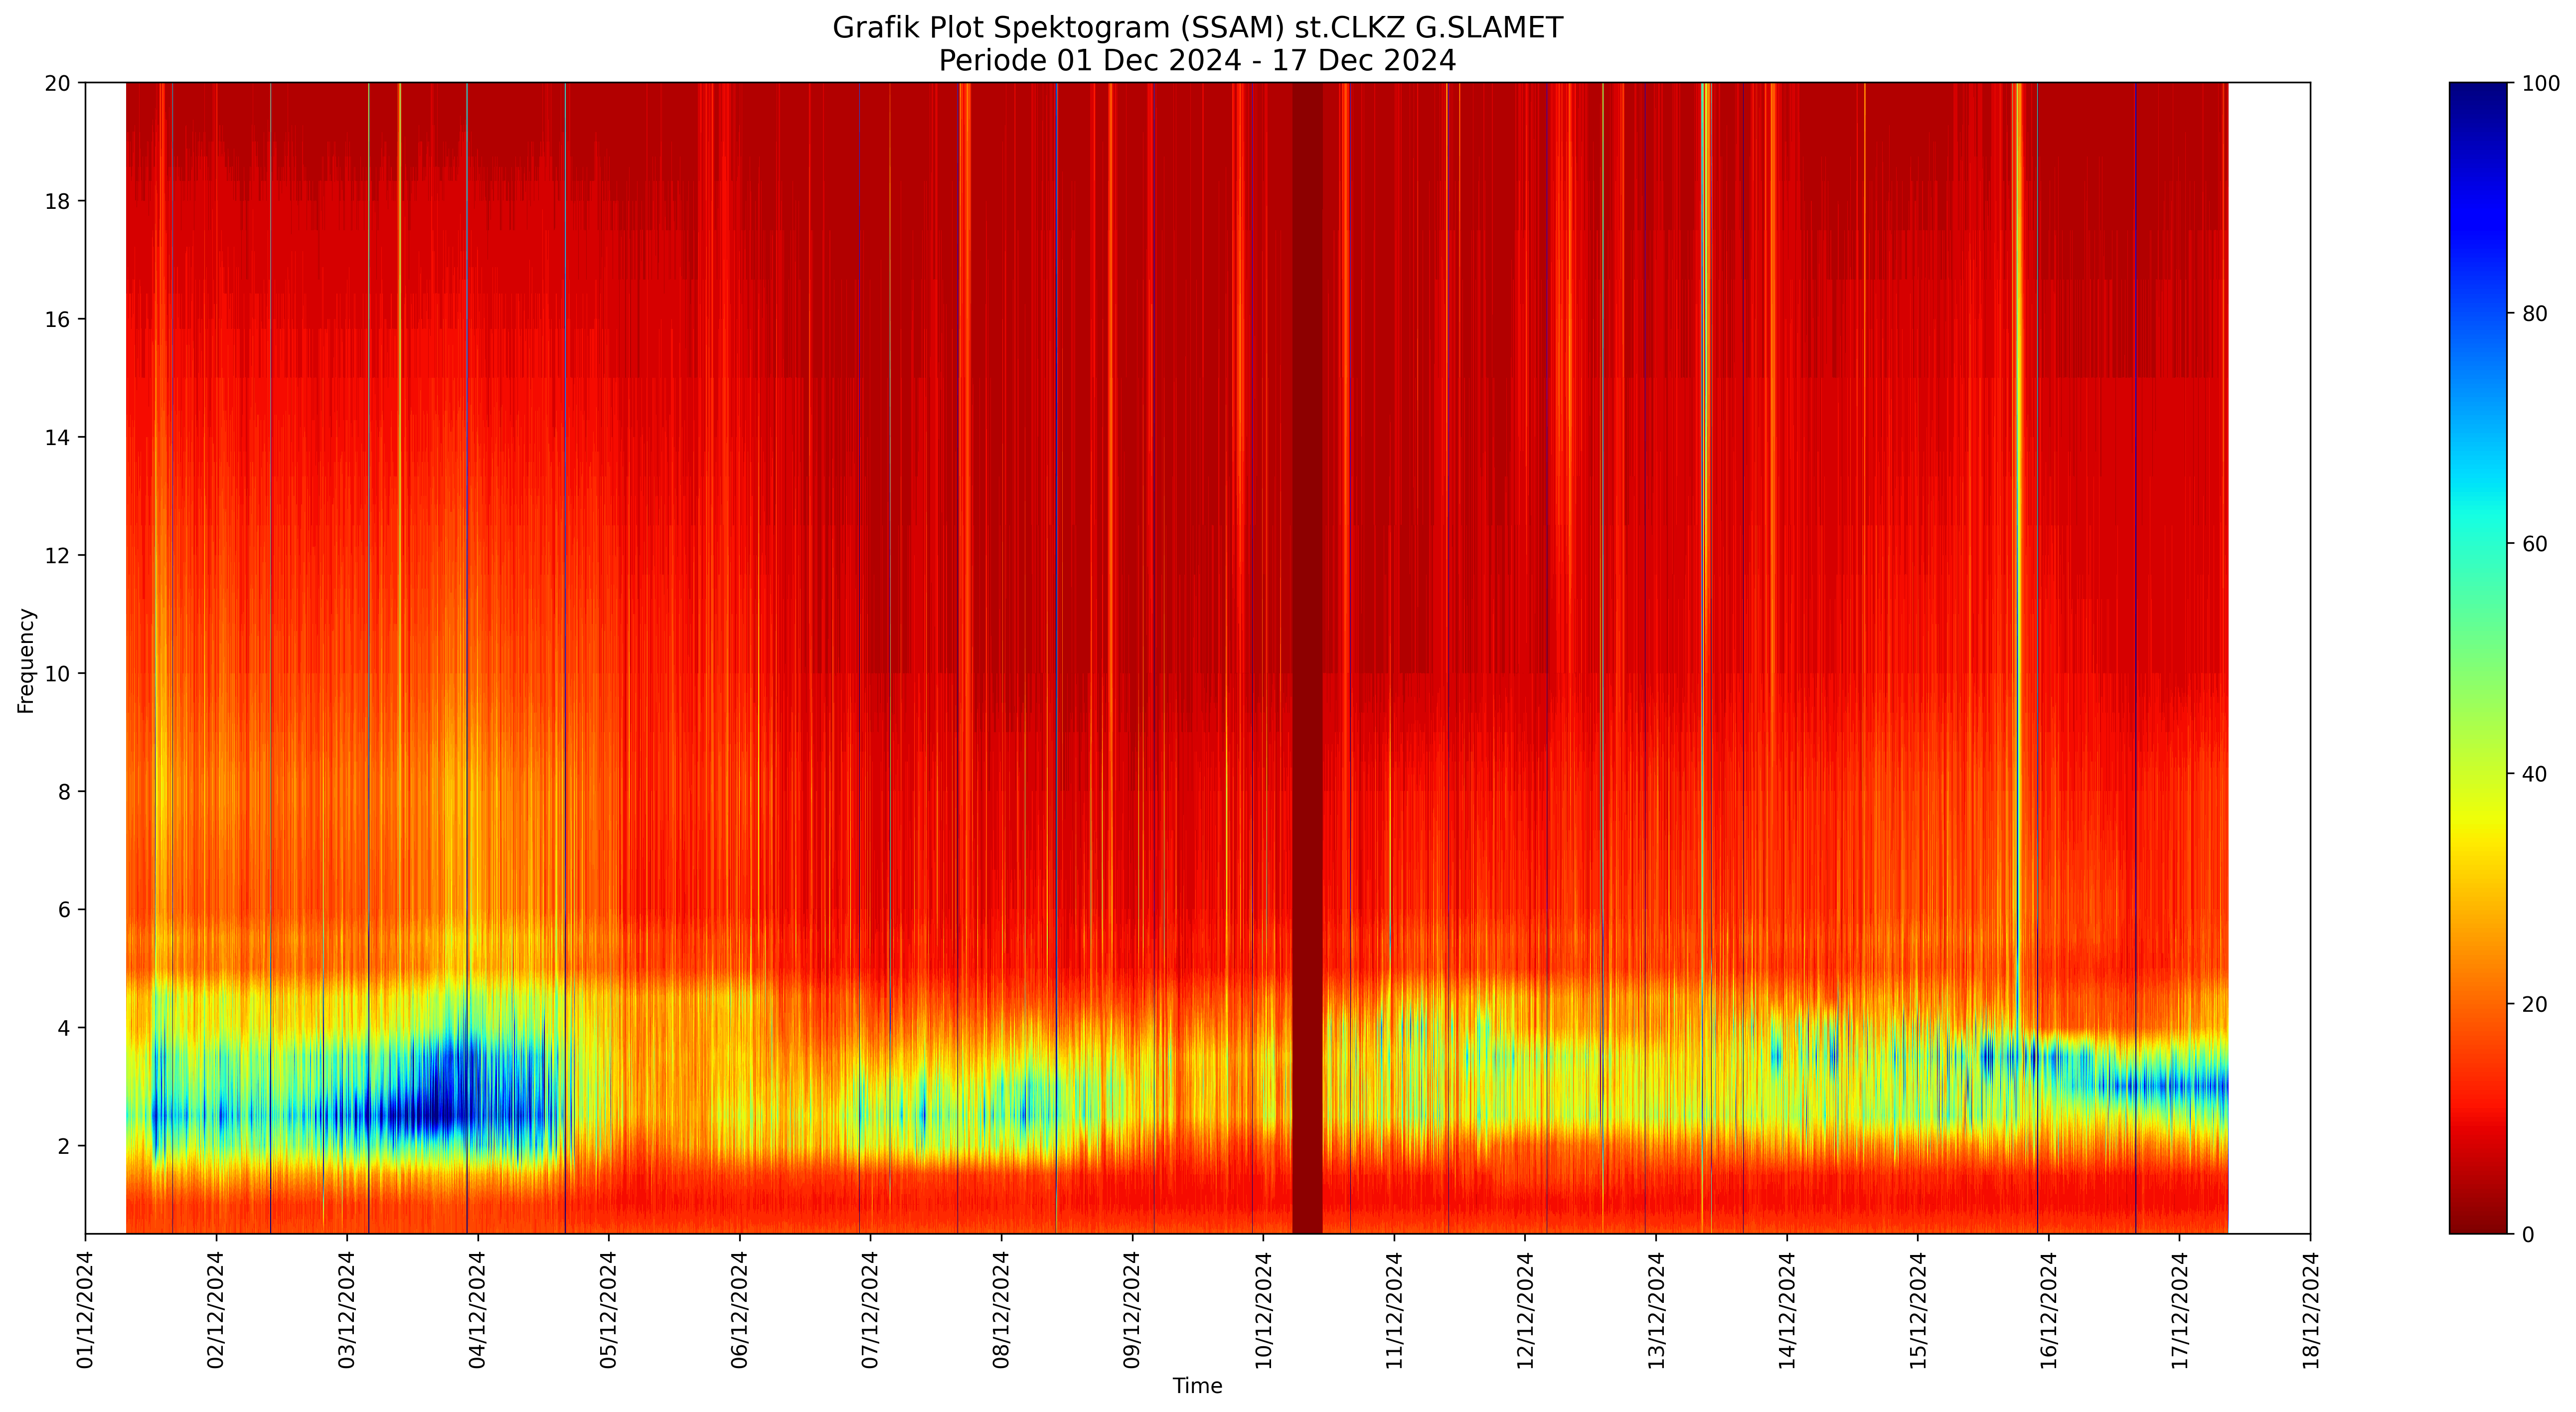

Data Terakhir : 17-December-2024 08:58 WIB


In [2]:
merged_data['DateTime'] = pd.to_datetime(merged_data['DateTime'], format='%d-%B-%Y %H:%M:%S')
merged_data.columns = range(merged_data.columns.size)

# Mengisi baris kosong dengan nilai 0 agar grafik tidak bolong
new_rows = []
for i in range(1, len(merged_data)):
    prev_time = merged_data.iloc[i-1, 0]
    curr_time = merged_data.iloc[i, 0]
    time_diff = curr_time - prev_time

    if time_diff > pd.Timedelta(minutes=1):
        new_time = prev_time + pd.Timedelta(minutes=1)
        while new_time < curr_time:
            new_row = [new_time] + [0] * (len(merged_data.columns) - 1)
            new_rows.append(new_row)
            new_time += pd.Timedelta(minutes=1)

new_data = pd.concat([merged_data, pd.DataFrame(new_rows, columns=merged_data.columns)])
new_data = new_data.sort_values(0)
new_data = new_data.reset_index(drop=True)

if pd.isna(new_data.iloc[-1, 0]):
    new_data = new_data.drop(new_data.index[-1])

# Extract data menjadi array terpisah sebagai nilai x, y, dan z.
# Waktu akan digunakan sebagai nilai x, frekuensi sebagai y, dan power sebagai z
# Sesuaikan format waktu file data dengan format waktu di bawah.
# Contoh '%m/%d/%Y %H:%M' artinya mm/dd/yyyy hh:mm, '%d/%m/%Y %H:%M' untuk dd/mm/yyy hh:mm. dan sebagainya.
time = pd.to_datetime(new_data[0], format='%d/%m/%Y %H:%M')
freq = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 8, 10, 15, 20])
power = new_data.iloc[:, 1:].values

# Menentukan nilai power minimum dan maksimum yang akan diplot
# Gunakan angka vmax rendah <100 apabila energinya rendah.
vmin = 0
vmax = 100
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Membuat legend colorbar berdasarkan nilai vmin dan vmax
sm = plt.cm.ScalarMappable(cmap='jet_r', norm=norm)

# Melakukan plotting data
# Nilai figsize menentukan ukuran gambar (p, l) dalam inchi.
# Nilai dpi menentukan resolusi gambar, semakin tinggi, resolusi gambar akan semakin tinggi, begitu juga ukuran file gambar.
# Nilai levels menentukan nilai gradasi warna, semakin tinggi gambar akan semakin halus.
fig, ax = plt.subplots(figsize=(24, 10), dpi=300)
c = ax.contourf(time, freq, power.T, levels=500, cmap='jet_r', norm=norm)
colorbar = fig.colorbar(sm, ax=ax)

# Menentukan interval axis y (frekuensi)
# Masukkan nilai interval y ke dalam tanda kurung MultipleLocator().
y_ticks = mticker.MultipleLocator(2)
ax.yaxis.set_major_locator(y_ticks)
ax.set_ylim([0.5, 20])

# Menentukan interval axis x (waktu)
# Rotation untuk memutar text tanggal, 90 akan membuat tulisan tegak dari bawah ke atas.
days = mdates.DayLocator(interval=interval_hari)
ax.xaxis.set_major_locator(days)
plt.xticks(rotation=90)

# Menentukan format label axis x  pada gambar
# Masukkan format waktu ke dalam tanda kurung DateFormatter().
date_format = mdates.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(date_format)
start_time = datetime.strptime(waktu_awal, '%d-%m-%Y')
end_time = datetime.strptime(waktu_akhir, '%d-%m-%Y')
ax.set_xlim([start_time, end_time + timedelta(days=1)])

# Nilai labelsize digunakan untuk mengatur ukuran font axis x :
plt.rc('xtick', labelsize=10)
# Nilai labelsize digunakan untuk mengatur ukuran font axis y :
plt.rc('ytick', labelsize=10)

# Set teks dan ukuran font label axis x :
ax.set_xlabel('Time', fontsize=10)
# Set teks dan ukuran font label axis y :
ax.set_ylabel('Frequency', fontsize=10)

# Set teks dan ukuran font judul :
ax.set_title(f'Grafik Plot Spektogram (SSAM) st.{stasiun} G.{gunung}\nPeriode {start_time.strftime("%d %b %Y")} - {end_time.strftime("%d %b %Y")}', fontsize=14)

# Menampilkan gambar hasil plot
plt.show()

last_row = merged_data.iloc[-1]
timestamp_terakhir = last_row[0].strftime('%d-%B-%Y %H:%M')
print("Data Terakhir :", timestamp_terakhir, "WIB")

# Mukijo-PVMBG, 2023
# 0856-4334-6785